In [64]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing import image as pre_image

**DATA PREPROCESSING**

In [9]:
input_folder = r"C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\cell_images\Parasitized"
output_folder = r"C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\Parasitized"
target_size = (224, 224)

# Iterate through each file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        # Open the image
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Resize the image
        img_resized = img.resize(target_size)

        # Save the resized image to the output folder
        output_path = os.path.join(output_folder, filename)
        img_resized.save(output_path)


In [11]:
# Open the image to be observed
image_path = r"C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\test\test_parasitized\C37BP2_thinF_IMG_20150620_133205a_cell_88.png"
img = Image.open(image_path)

# Get the dimensions of the image
width, height = img.size

print("Image Width:", width)
print("Image Height:", height)

Image Width: 224
Image Height: 224


**DATA SPLITTING**

In [ ]:
def dataset_split(input_dir, test_output_dir, train_output_dir, split_ratio=0.2):
    # list all the images in the input directory
    imgs = os.listdir(input_dir)
    # Shuffle the list to get a random selection
    random.shuffle(imgs)

    # Calculate the split indices
    split_index = int(len(imgs) * split_ratio)

    # Spliting  files into 20% and 80%
    test_data = imgs[:split_index]
    train_data = imgs[split_index:]

    # move images into there respective directories
    for i in test_data:
        input_path = os.path.join(input_dir, i)
        output_path = os.path.join(test_output_dir, i)
        shutil.copy(input_path, output_path)

    for i in train_data:
        input_path = os.path.join(input_dir, i)
        output_path = os.path.join(train_output_dir, i)
        shutil.copy(input_path, output_path)

In [ ]:
# Path to the directories you wish to
Parasite_path = 'C:/Users/ehiat/Documents/pythomproject4/NCAIR Group A/resized_cell_images/Parasitized'
Uninfect_path = 'C:/Users/ehiat/Documents/pythomproject4/NCAIR Group A/resized_cell_images/Uninfected'

test_par_dir = 'C:/Users/ehiat/Documents/pythomproject4/NCAIR Group A/resized_cell_images/test/test_parasitized'
train_par_dir = 'C:/Users/ehiat/Documents/pythomproject4/NCAIR Group A/resized_cell_images/train/train_parasitized'

test_uni_dir = 'C:/Users/ehiat/Documents/pythomproject4/NCAIR Group A/resized_cell_images/test/test_uninfected'
train_uni_dir = 'C:/Users/ehiat/Documents/pythomproject4/NCAIR Group A/resized_cell_images/train/train_uninfected'

dataset_split(Uninfect_path, test_uni_dir, train_uni_dir, split_ratio=0.2)

**DATA VISUALIZATION**

In [13]:
def count_images_in_directory(directory_path):
    # List all files in the directory
    files = os.listdir(directory_path)

    # Count the number of files with image extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
    image_count = sum(1 for file in files if os.path.splitext(file.lower())[1] in image_extensions)
    print(image_count)
    return image_count

In [15]:
def visualize_image_counts(parent_directory):
    # List all subdirectories in the parent directory
    subdirectories = [f.path for f in os.scandir(parent_directory) if f.is_dir()]

    # Count images in each subdirectory
    counts = []
    for subdirectory in subdirectories:
        count = count_images_in_directory(subdirectory)
        counts.append((os.path.basename(subdirectory), count))

    # Sort counts based on the number of images
    counts.sort(key=lambda x: x[1], reverse=True)

    # Visualize counts using a bar plot
    sns.set(style="whitegrid")

    
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x=[x[0] for x in counts], y=[x[1] for x in counts], palette="viridis")
    barplot.set(xlabel='Labels', ylabel='Number of Images', title='Image Counts in Labels')
    plt.xticks(rotation=45, ha='right')
    plt.show()

11024
11024


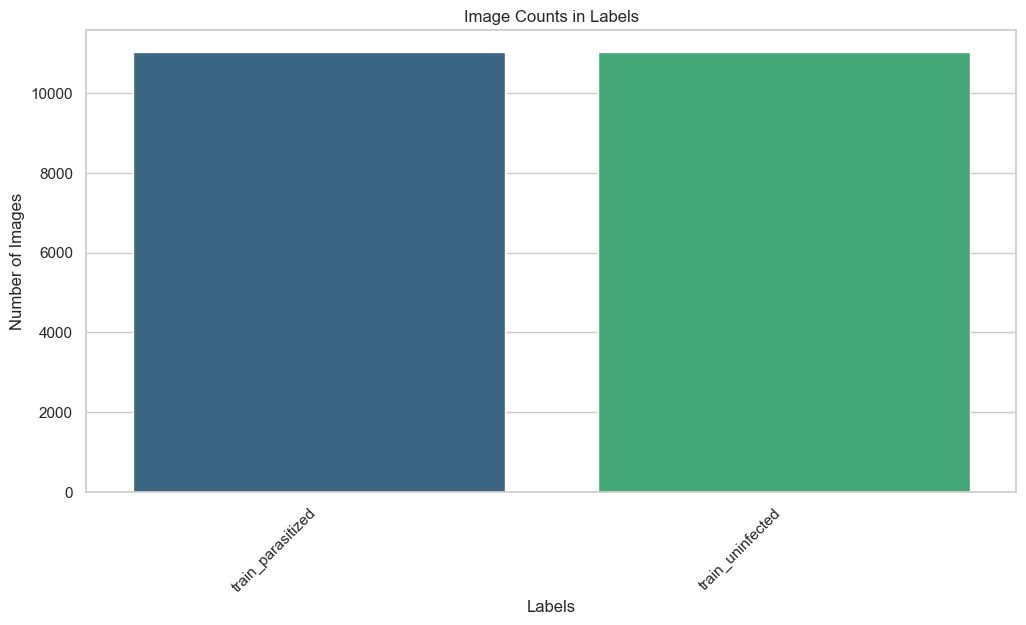

In [16]:
train_parent_directory = r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\train'
visualize_image_counts(train_parent_directory)

2755
2755


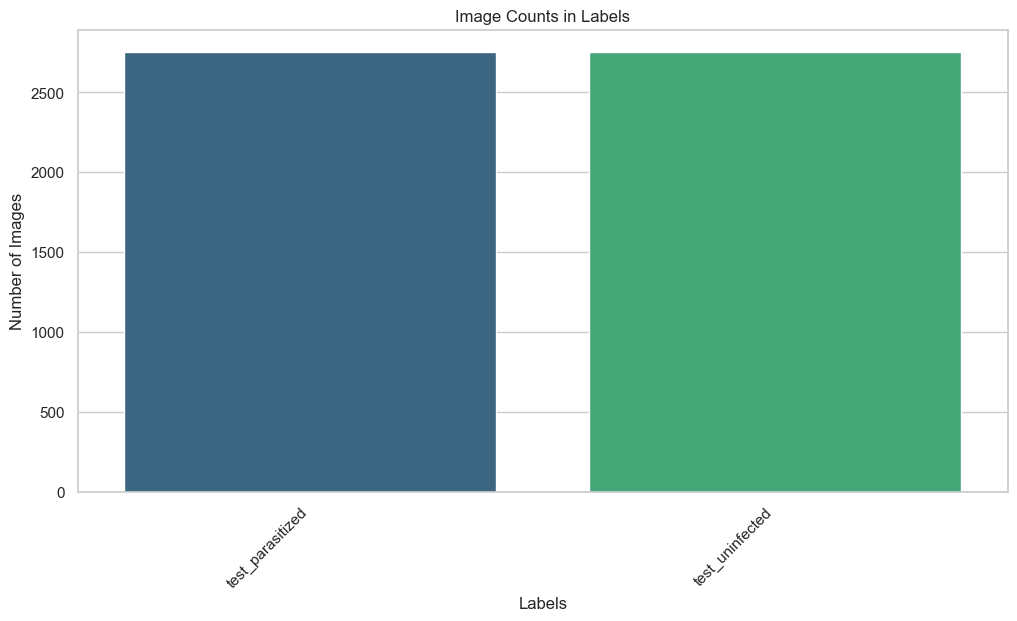

In [17]:
test_parent_directory = r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\test'
visualize_image_counts(test_parent_directory)

**MODEL BUILDING**

In [18]:
# Define the Model
model = Sequential()

# Creating the Layers

# Convulutional Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# to make a transition of convolutional layer to dense layer we add a flatten layer
model.add(Flatten())

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

**IMAGE GENERATION**

In [42]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 64
epochs = 10
# Number of classes in your dataset

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [43]:
# Data generator for the training set
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Data generator  for the test set (no data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


**TRAINING THE MODEL**

In [44]:
# Define the checkpoint path and filename
checkpoint_path = r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\model_beta_checkpoint.h5'

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # You can choose the metric to monitor, e.g., validation loss
    save_best_only=True,  # Save only the best models
    mode='min',  # 'min' if the monitored quantity should be minimized, 'max' if it should be maximized
    verbose=1,  # 1: display messages, 0: silent
    sve_freq='epoch'
)


In [45]:
# compiling Our Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# to display the Model Summary
model.summary
# load saved progress of the model to be compared
model.load_weights(r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\model_beta_checkpoint.h5')

In [46]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # total number of batches
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),  # total number of batches
    callbacks=[checkpoint]
)

Epoch 1/10
345/345 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9416
Epoch 1: val_accuracy improved from inf to 0.94428, saving model to C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\model_beta_checkpoint.h5
345/345 [==============================] - 1033s 3s/step - loss: 0.1784 - accuracy: 0.9416 - val_loss: 0.1790 - val_accuracy: 0.9443
Epoch 2/10
345/345 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9461
Epoch 2: val_accuracy did not improve from 0.94428
345/345 [==============================] - 1080s 3s/step - loss: 0.1658 - accuracy: 0.9461 - val_loss: 0.1533 - val_accuracy: 0.9546
Epoch 3/10
345/345 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9507
Epoch 3: val_accuracy did not improve from 0.94428
345/345 [==============================] - 1035s 3s/step - loss: 0.1570 - accuracy: 0.9507 - val_loss: 0.1504 - val_accuracy: 0.9544
Epoch 4/10
345/345 [========================

In [49]:
model.save(r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\model_alpha_malaria.h5')

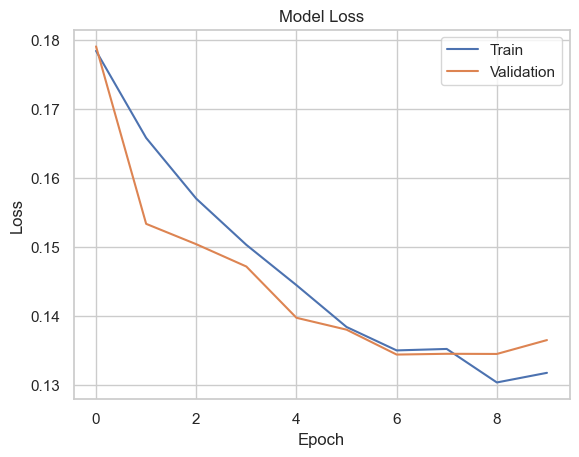

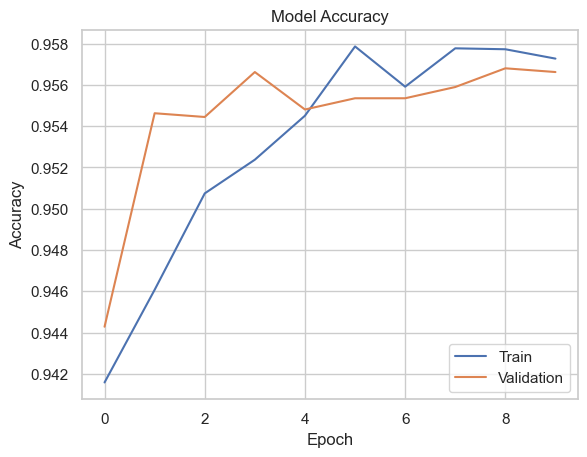

In [48]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [68]:
# Load the trained model
model = load_model(r'C:\Users\ehiat\Documents\pythomproject4\NCAIR Group A\resized_cell_images\model_alpha_malaria.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# Open a connection to the camera (0 represents the default camera)
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Preprocess the image for prediction
    img = cv2.resize(frame, (224, 224))
    img = pre_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Normalize pixel values to between 0 and 1

    # Make a prediction
    prediction = model.predict(img)
    
    # Display the result on the frame
    if prediction < 0.5:
        cv2.putText(frame, 'Parasitized', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        cv2.putText(frame, 'Uninfected', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('Prediction', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()